### Introduction:

Question and Answer on Documents which we provide .

### LangChain: Q&A over Documents

An example might be a tool that would allow you to query a product catalog for items of interest.

In [2]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [3]:
## RetrievalQA Chain - Will hep you retrieve information from the documents 
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
## Document Loader 
from langchain.document_loaders import CSVLoader
## DocArrayInMemorySearch - This is InMemory VectorStore . It doesnt require connecting to database
from langchain.vectorstores import DocArrayInMemorySearch
## This will help you to create VectorStore and Index
from langchain.indexes import VectorstoreIndexCreator
from IPython.display import display, Markdown

CSV File contains - Product Catalog (Name and Description)

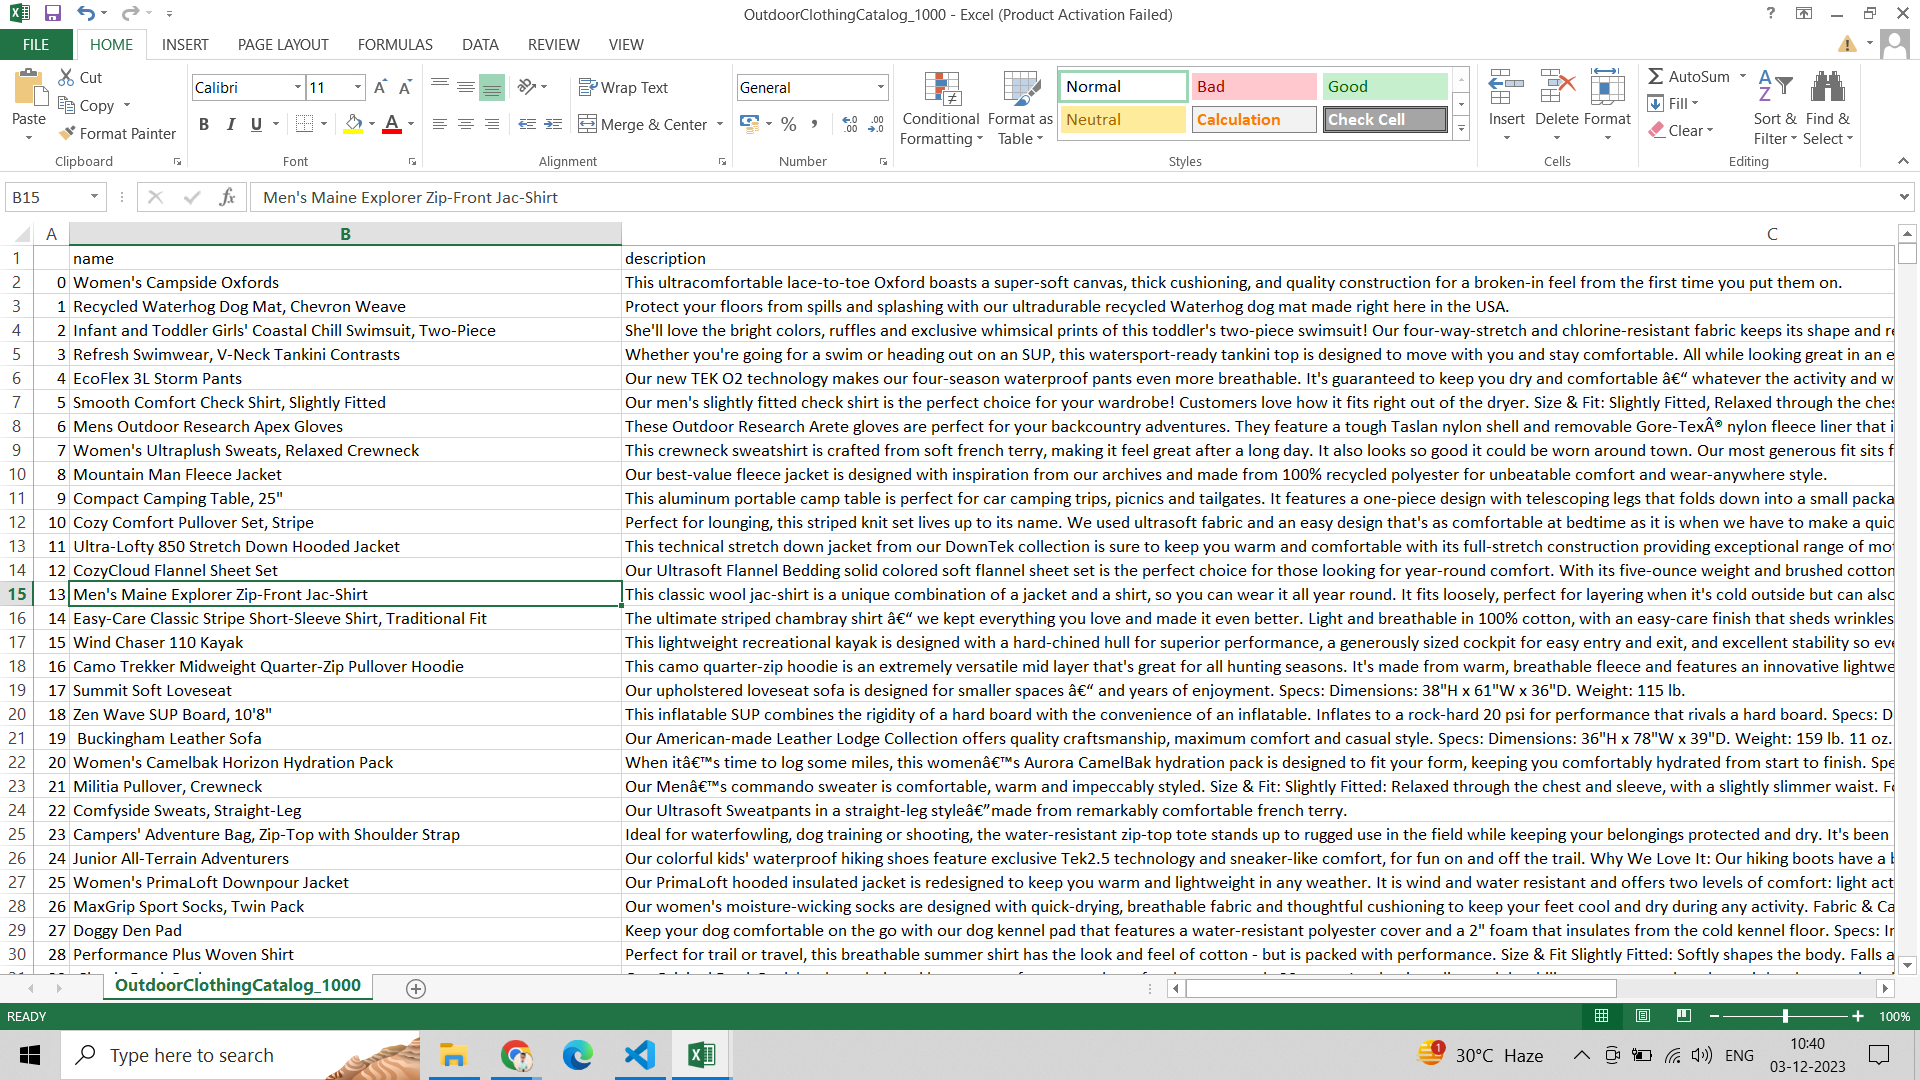


Now we know ,That language model can only inspect few thousand words at time .

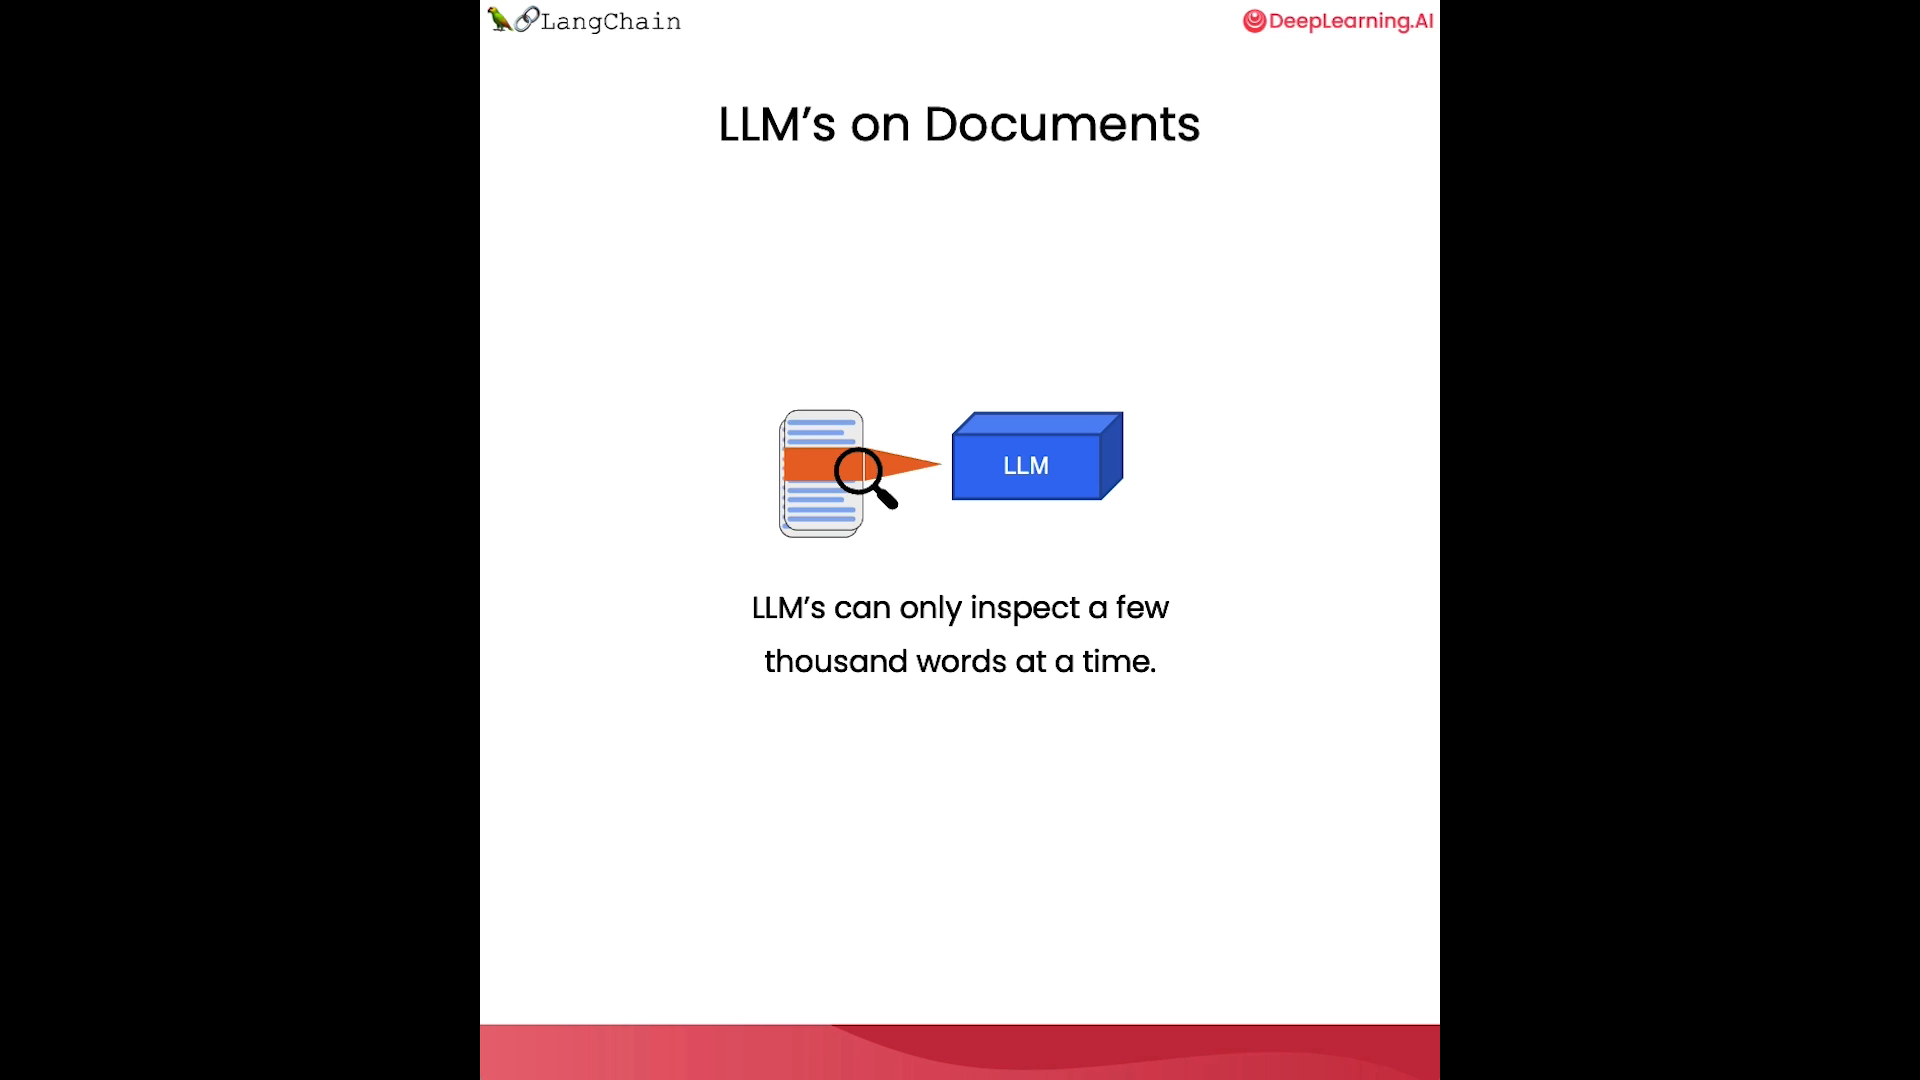


So if we have large Documents . We will have to use Vector store and embeddings 

Embeddings - Each word is converted into Vector . Words with Similar content will have same vectors 

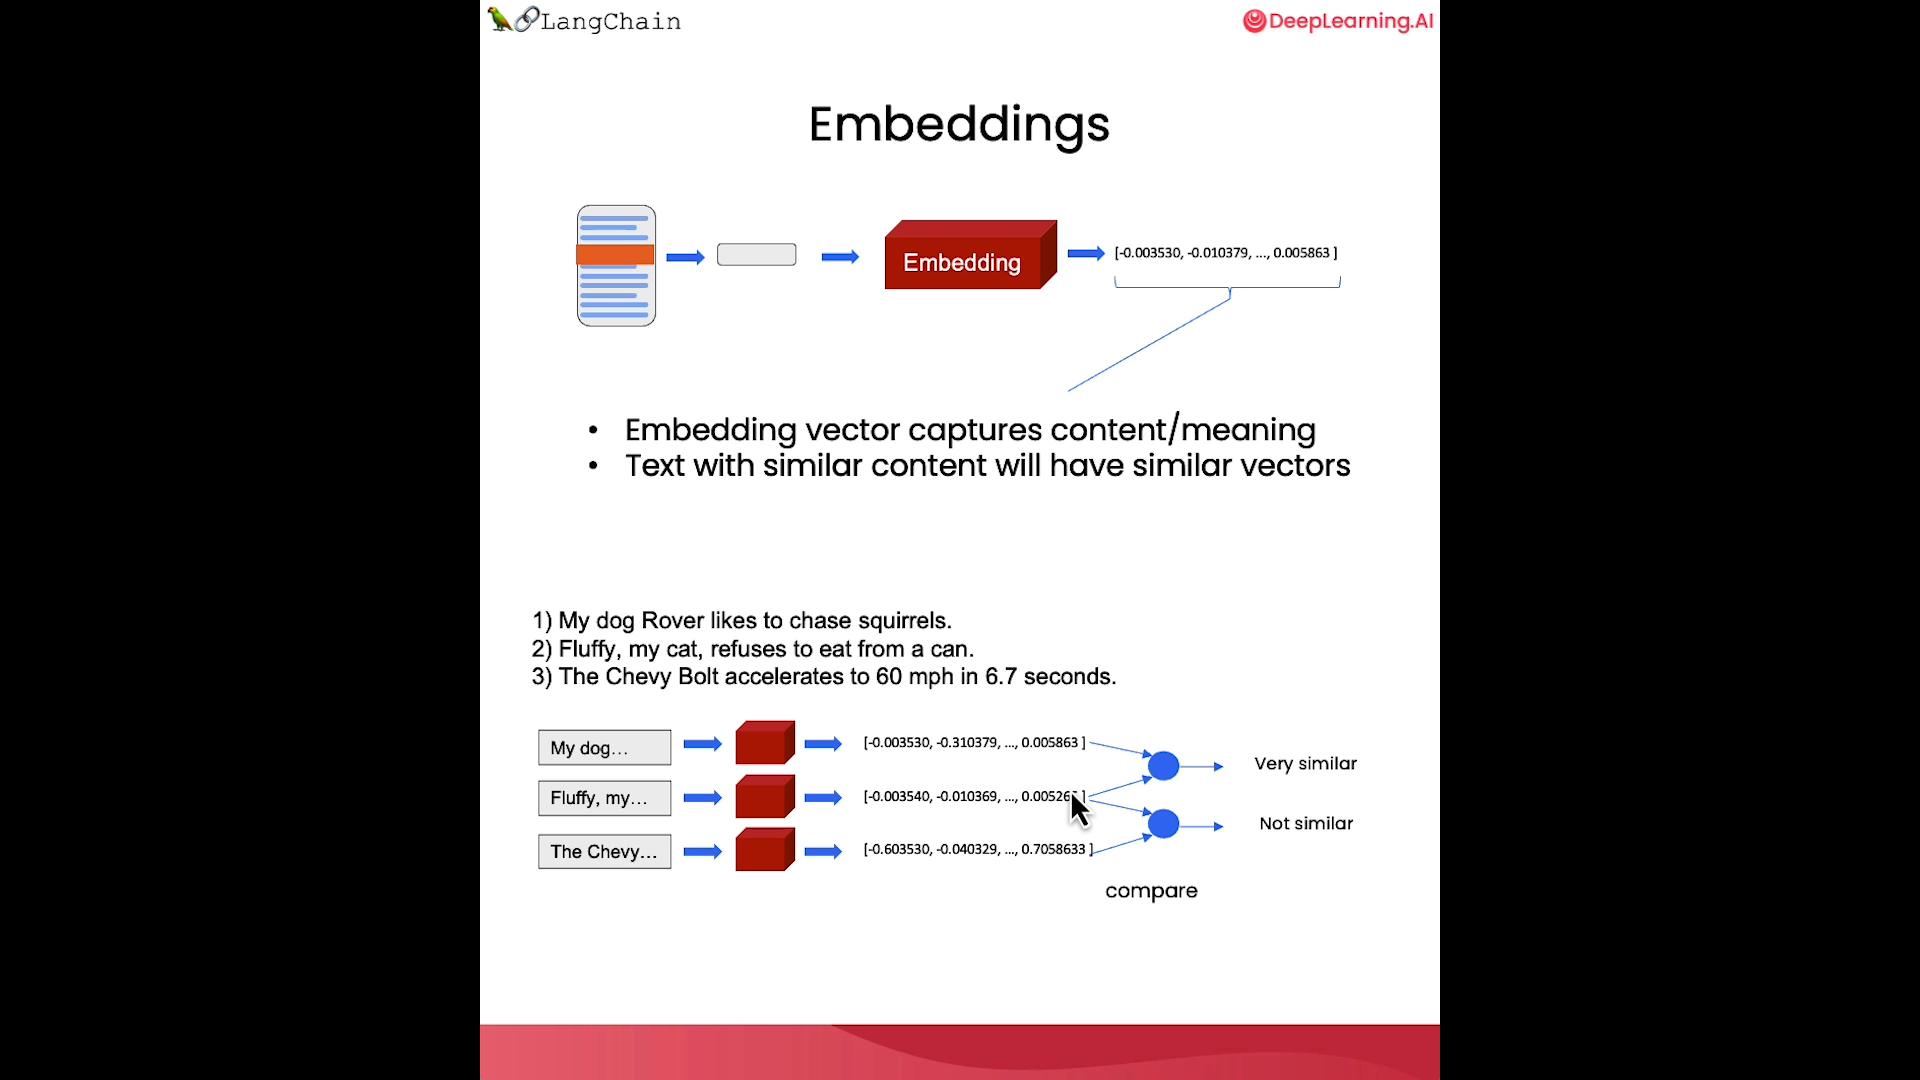

Vector Database 

Whenever we get a Document we do following steps :
- Break the document into Chunks 
- Create Embeddings of Chunks 
- Store this Embeddings in Vector Database 

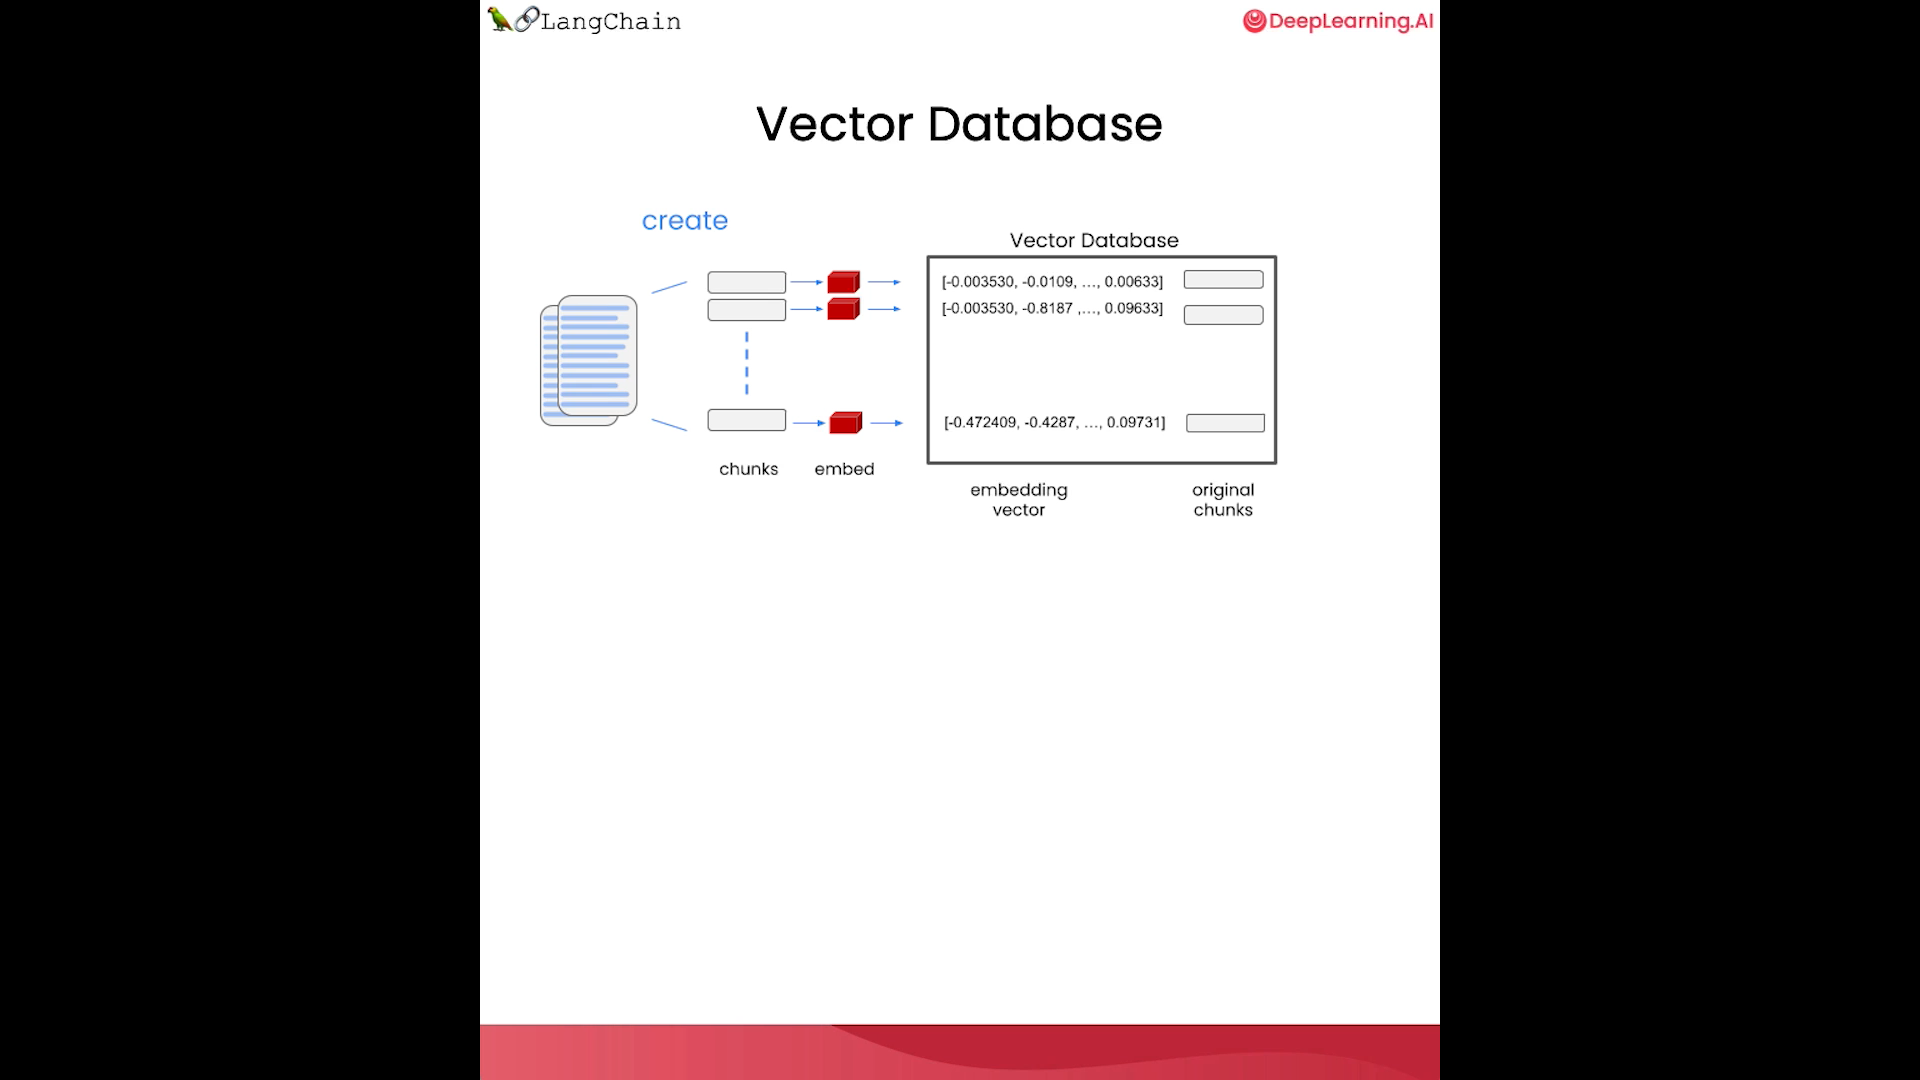

So whenever we have new Query/Question . 
- We create Embeddings of that query . 
- Search it into Vector database . 
- Compare it with all the entries which are available in Vector Database
- Get the Similar Vectors

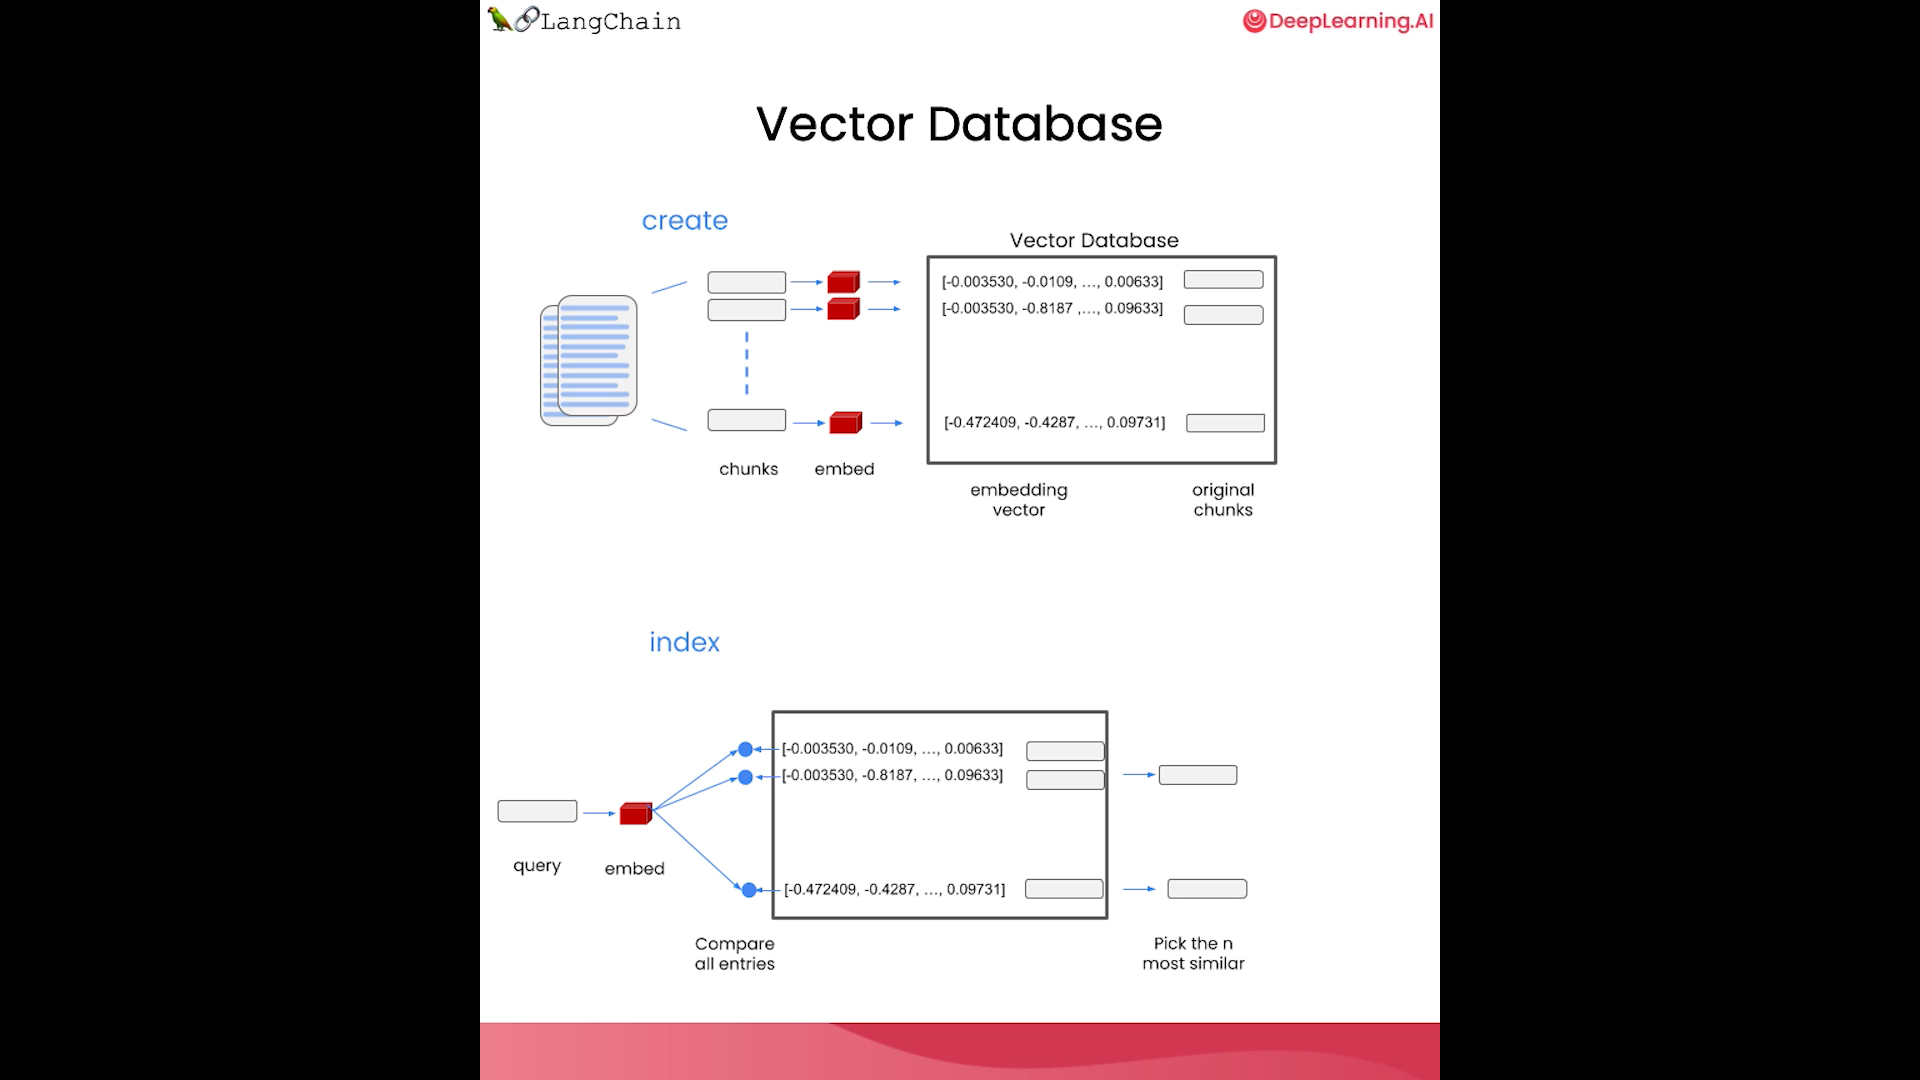

The similar vectors which are returned from Above Query . Will then be passed to LLM tr get the final answer

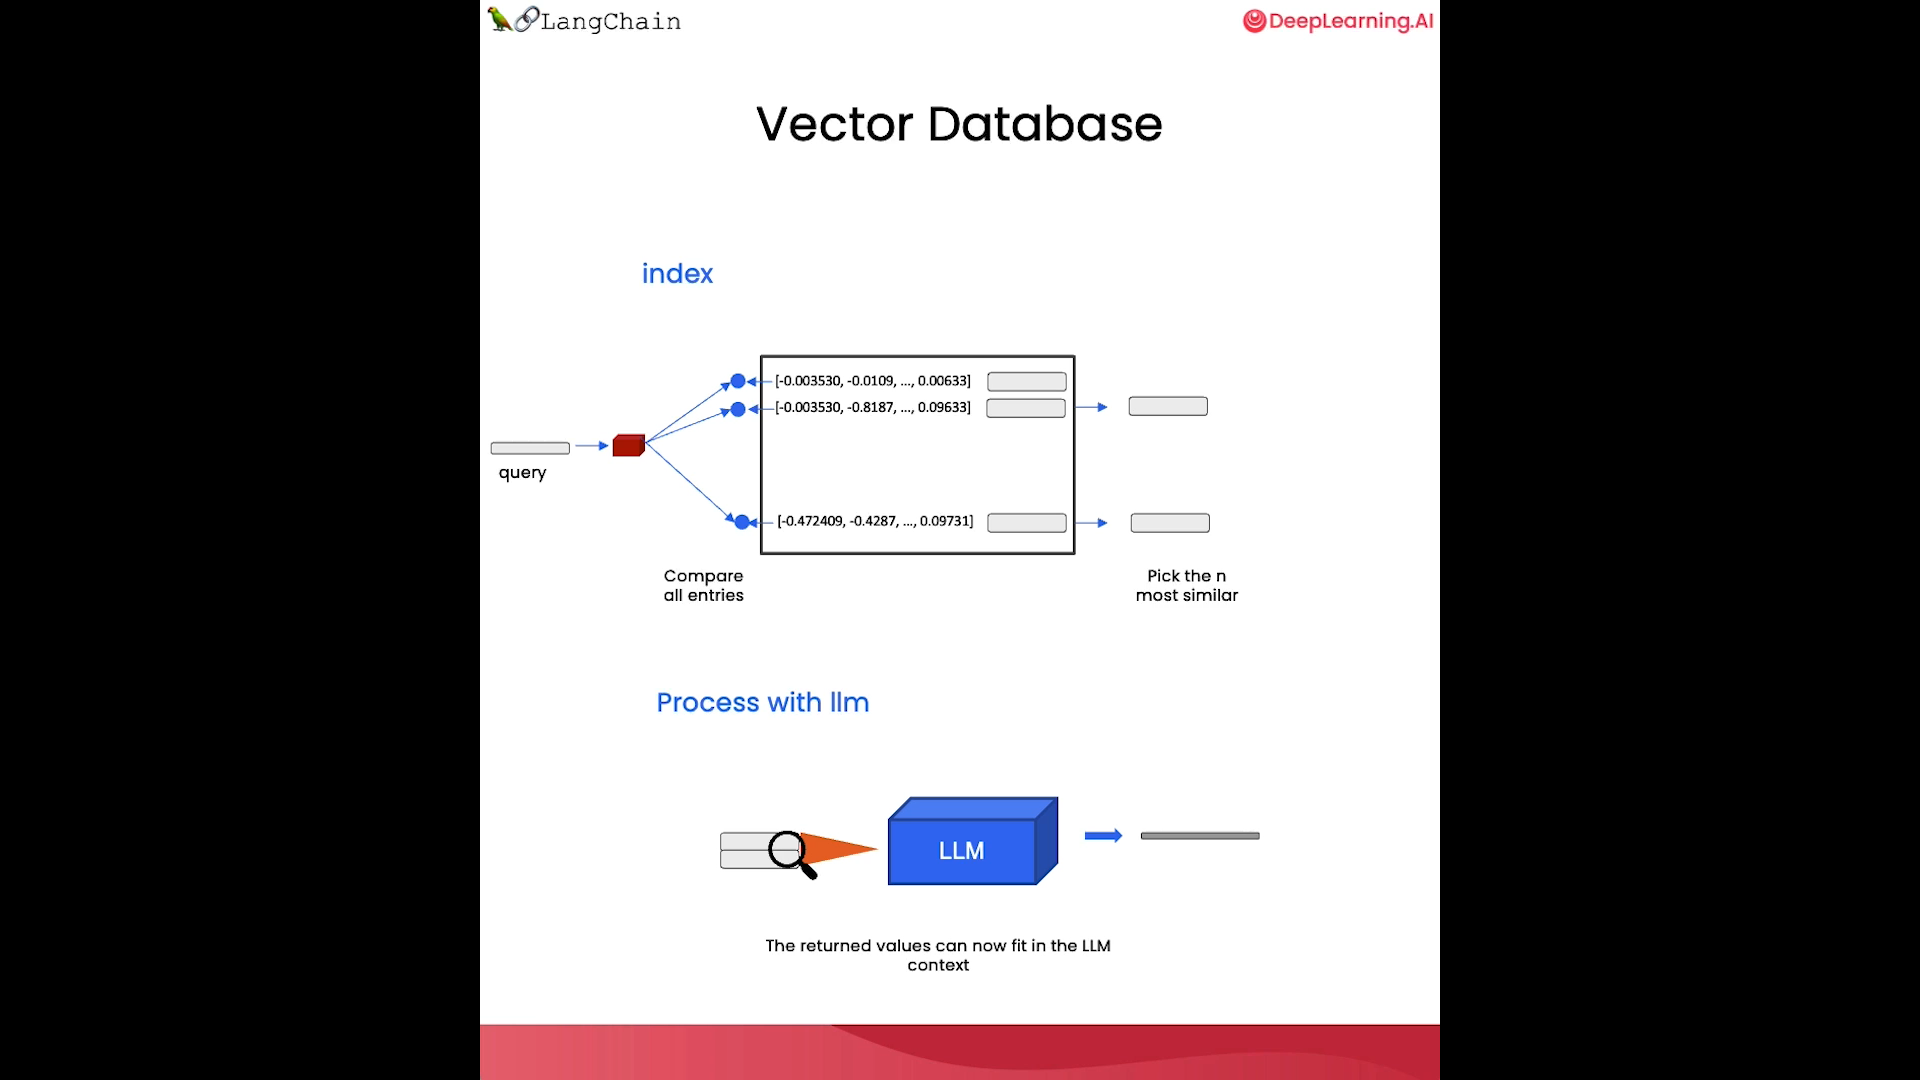

###  Step By Step Process

In [14]:
from langchain.document_loaders import CSVLoader
loader = CSVLoader(file_path=file)
docs = loader.load()
docs[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

Now we will create the embeddings and store it in Vector Database - In Memory using DocArrayInMemoy

Since this documents are already small. We dont have to create chunks . We can directly create embeddings 

In [15]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

## Lets see what happens . When we create Embeddings of particular text 
embed = embeddings.embed_query("Hi my name is Harrison")
print(len(embed))

1536


In [16]:
print(embed[:5])

[-0.021867523073664935, 0.006806864435505969, -0.018180996265900713, -0.03910486791222713, -0.01406668040129443]


We will create Embeddings of the Document loades from CSV and store in Vector Store DB - In our case it is DocArrayInMemorySearch 

In [17]:
db = DocArrayInMemorySearch.from_documents(
    docs, 
    embeddings
)

In [18]:
query = "Please suggest a shirt with sunblocking"
docs = db.similarity_search(query)
len(docs)

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for text-embedding-ada-002 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..


4

In [19]:
docs[0]

Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\n\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\n\nSun Protection That Won\'t Wear Off\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255})

So whenever we ask question. We will  get similar docs from VectorDb.
How we will create QA from documments which are used 

- Create Retriever from VectorDB    
- Since we have to give Natural Language Response. We will us LLM .
- I/p of above LLM will be similar vector retrieved from DB
- O/p will be natural language response.

There are 2 methods of passing i/p(Similar vectors) to LLM. Since we will be using Stuff Method.

We will have to combine all the text (similar text/vectors) which we got from Vector DB .And pass this summary into LLM 

In [20]:
retriever = db.as_retriever()
llm = ChatOpenAI(temperature = 0.0, model=llm_model)
## Combining all the docs received from vector db into single text 
qdocs = "".join([docs[i].page_content for i in range(len(docs))])
print(qdocs)

: 255
name: Sun Shield Shirt by
description: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. 

Size & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.

Fabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.

Additional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.

Sun Protection That Won't Wear Off
Our high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun's harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.: 374
name: Men's Plaid Tropic Shirt, Short-Sleeve
description: Our Ultracomfortable sun protection is rated to UPF 50+, helping you stay cool and dry. Originally designed for fishing, this lightest hot-weather shirt offers UPF 50+ coverage and is gr

Pass above string into LLM

In [21]:
response = llm.call_as_llm(f"{qdocs} Question: Please list all your \
shirts with sun protection in a table in markdown and summarize each one.") 
display(Markdown(response))

| Name | Description |
| --- | --- |
| Sun Shield Shirt | High-performance sun shirt with UPF 50+ sun protection, moisture-wicking, and abrasion-resistant fabric. Recommended by The Skin Cancer Foundation. |
| Men's Plaid Tropic Shirt | Ultracomfortable shirt with UPF 50+ sun protection, wrinkle-free fabric, and front/back cape venting. Made with 52% polyester and 48% nylon. |
| Men's TropicVibe Shirt | Men's sun-protection shirt with built-in UPF 50+ and front/back cape venting. Made with 71% nylon and 29% polyester. |
| Men's Tropical Plaid Short-Sleeve Shirt | Lightest hot-weather shirt with UPF 50+ sun protection, front/back cape venting, and two front bellows pockets. Made with 100% polyester. |

All of these shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. They are made with high-performance fabrics that are moisture-wicking, wrinkle-resistant, and abrasion-resistant. The Men's Plaid Tropic Shirt and Men's Tropical Plaid Short-Sleeve Shirt both have front/back cape venting for added breathability. The Sun Shield Shirt is recommended by The Skin Cancer Foundation as an effective UV protectant.

### All above steps are already done in RetrievalQA Chain

- We have created Embeddings using OpenAI . 
- Stored that embeddings into DocArrayInMemorySearch Vector DB
- Create a retriever object from that db
- Pass that retriever object into RetrievalQA Chain
- Since we are using Stuff method . Ouptut of Vector DB will be summmarized and passed into LLM in last stage. Which will later then give us final output 

In [22]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

In [23]:
query =  "Please list all your shirts with sun protection in a table \
in markdown and summarize each one."
response = qa_stuff.run(query)
display(Markdown(response))



> Entering new RetrievalQA chain...

> Finished chain.


| Shirt Number | Name | Description |
| --- | --- | --- |
| 618 | Men's Tropical Plaid Short-Sleeve Shirt | This shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 374 | Men's Plaid Tropic Shirt, Short-Sleeve | This shirt is made with 52% polyester and 48% nylon. It is machine washable and dryable. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+. |
| 535 | Men's TropicVibe Shirt, Short-Sleeve | This shirt is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 255 | Sun Shield Shirt | This shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is handwashable and line dry. It is rated UPF 50+ for superior protection from the sun's UV rays. It is abrasion-resistant and wicks moisture for quick-drying comfort. |

All of these shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. They are all designed to be lightweight and comfortable in hot weather. They all have front and back cape venting that lets in cool breezes and two front bellows pockets. The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant. The Men's Plaid Tropic Shirt, Short-Sleeve is made with 52% polyester and 48% nylon. The Men's TropicVibe Shirt, Short-Sleeve is made of 71% Nylon and 29% Polyester. The Sun Shield Shirt is made of 78% nylon and 22% Lycra Xtra Life fiber.

In [24]:
### We can get same above answer with one line code as well
### Loader - CSV Loader 
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)
loader

In [25]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

Now we can ask Questions - Get similar vectors based on Questions asked 

In [26]:
## pip install --upgrade pydantic==1.10.13
query ="Please list all your shirts with sun protection \
in a table in markdown and summarize each one."
## Without using LLM ,We will only get vectors
response = index.query(query)
display(Markdown(response))



| Name | Description |
| --- | --- |
| Men's Tropical Plaid Short-Sleeve Shirt | UPF 50+ rated, 100% polyester, wrinkle-resistant, front and back cape venting, two front bellows pockets |
| Men's Plaid Tropic Shirt, Short-Sleeve | UPF 50+ rated, 52% polyester and 48% nylon, machine washable and dryable, front and back cape venting, two front bellows pockets |
| Men's TropicVibe Shirt, Short-Sleeve | UPF 50+ rated, 71% Nylon, 29% Polyester, 100% Polyester knit mesh, wrinkle resistant, front and back cape venting, two front bellows pockets |
| Sun Shield Shirt by | UPF 50+ rated, 78% nylon, 22% Lycra Xtra Life fiber, wicks moisture, fits comfortably over swimsuit, abrasion resistant |

All four shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant. The Men's Plaid Trop

In [27]:
response = index.query(query, llm=llm)
display(Markdown(response))

| Shirt Number | Name | Description |
| --- | --- | --- |
| 618 | Men's Tropical Plaid Short-Sleeve Shirt | This shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 374 | Men's Plaid Tropic Shirt, Short-Sleeve | This shirt is made with 52% polyester and 48% nylon. It is machine washable and dryable. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+. |
| 535 | Men's TropicVibe Shirt, Short-Sleeve | This shirt is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 255 | Sun Shield Shirt | This shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is handwashable and line dry. It is rated UPF 50+ for superior protection from the sun's UV rays. It is abrasion-resistant and wicks moisture for quick-drying comfort. |

All of these shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. They are all designed to be lightweight and comfortable in hot weather. They all have front and back cape venting that lets in cool breezes and two front bellows pockets. The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant. The Men's Plaid Tropic Shirt, Short-Sleeve is made with 52% polyester and 48% nylon. The Men's TropicVibe Shirt, Short-Sleeve is made of 71% Nylon and 29% Polyester. The Sun Shield Shirt is made of 78% nylon and 22% Lycra Xtra Life fiber and is abrasion-resistant and wicks moisture for quick-drying comfort.

### Now Lets add embeddings which are created by OpenAI

In [28]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeddings,
).from_loaders([loader])
response = index.query(query, llm=llm)
display(Markdown(response))

| Shirt Number | Name | Description |
| --- | --- | --- |
| 618 | Men's Tropical Plaid Short-Sleeve Shirt | This shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 374 | Men's Plaid Tropic Shirt, Short-Sleeve | This shirt is made with 52% polyester and 48% nylon. It is machine washable and dryable. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+. |
| 535 | Men's TropicVibe Shirt, Short-Sleeve | This shirt is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 255 | Sun Shield Shirt | This shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is handwashable and line dry. It is rated UPF 50+ for superior protection from the sun's UV rays. It is abrasion-resistant and wicks moisture for quick-drying comfort. |

The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays.

The Men's Plaid Tropic Shirt, Short-Sleeve is made with 52% polyester and 48% nylon. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+.

The Men's TropicVibe Shirt, Short-Sleeve is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays.

The Sun Shield Shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is abrasion-resistant and wicks moisture for quick-drying comfort. It is rated UPF 50+ for superior protection from the sun's UV rays. It is handwashable and line dry.

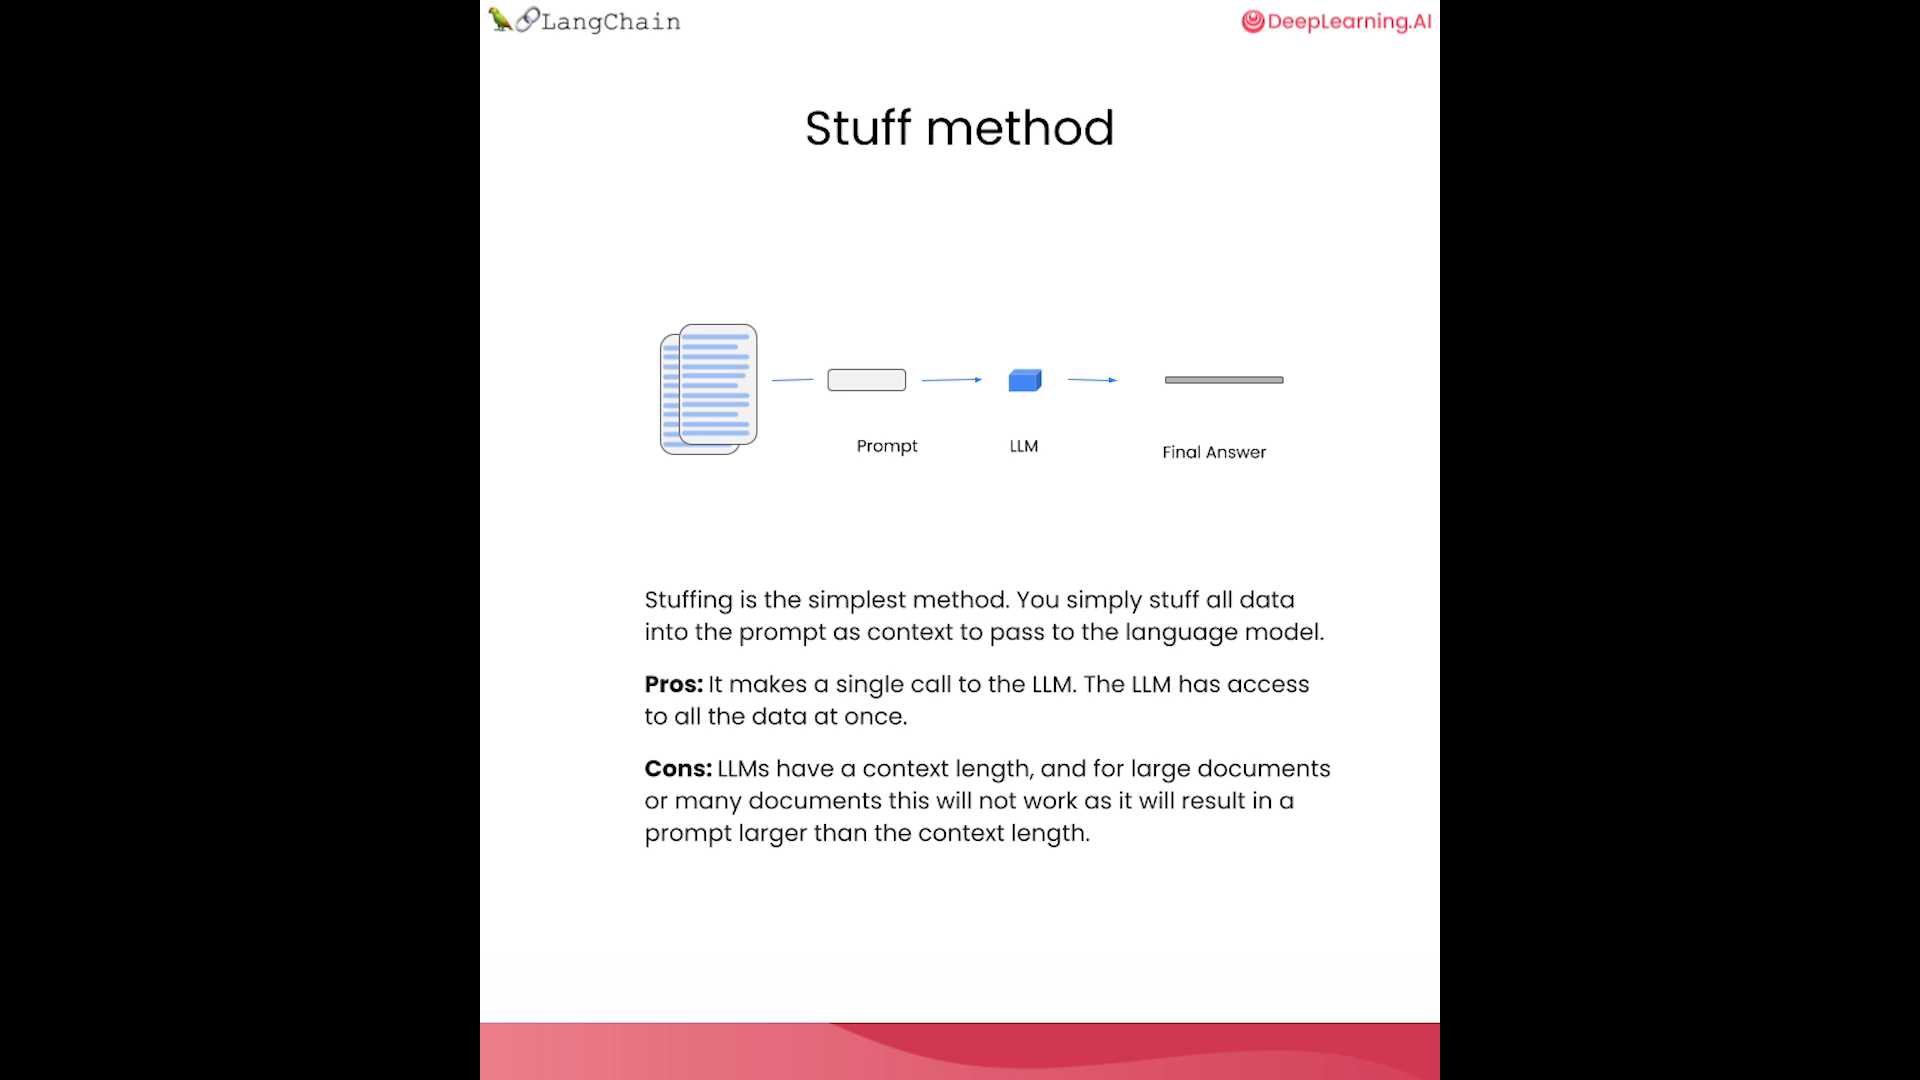

Other Methods:

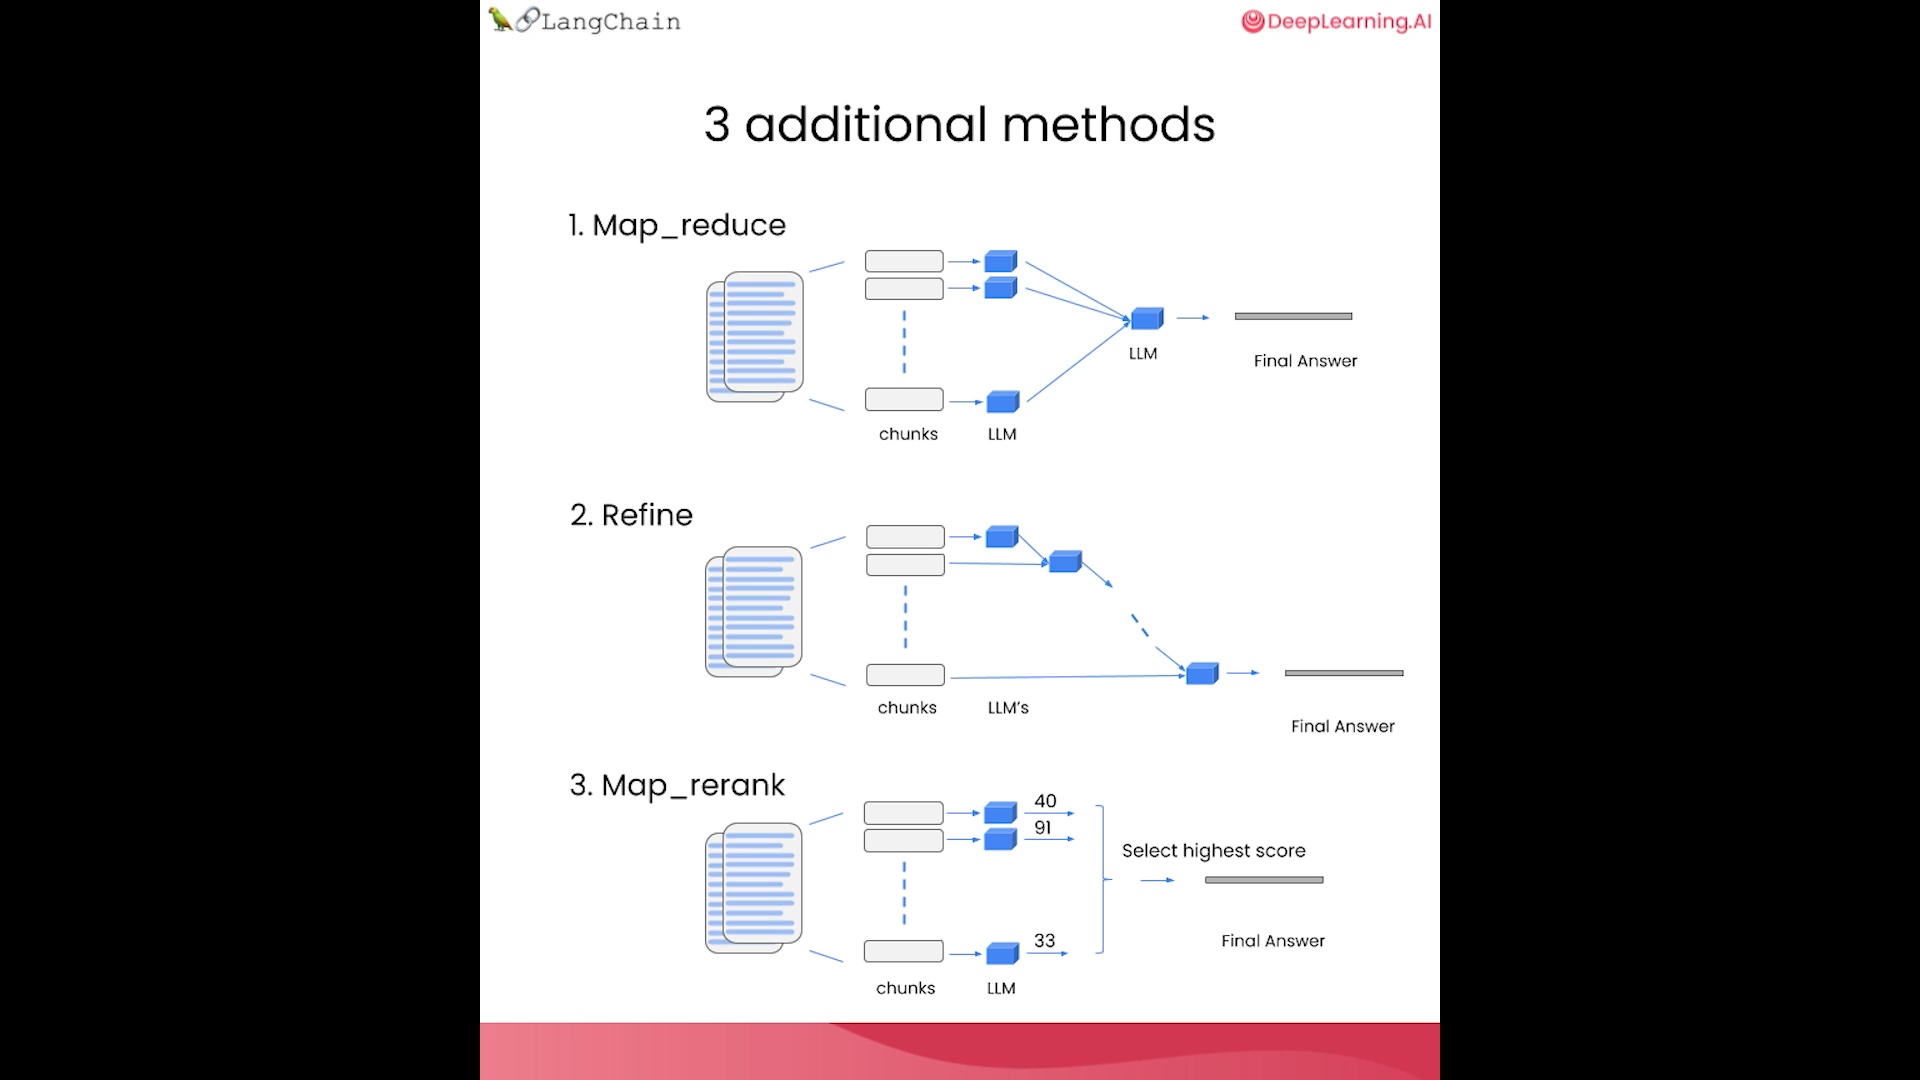